# Car Detection and Counting using DETR

This notebook demonstrates how to use the DETR (DEtection TRansformer) model from Hugging Face to detect and count vehicles (cars, trucks, and motorcycles) in images.

In [1]:
# # Install required packages
# !pip install transformers torch torchvision pillow

In [2]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the DETR model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")


/Users/arturopolancolozano/opt/anaconda3/envs/huggingface/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def load_image(image_path):
    """Load an image from a file path or URL and ensure it's in RGB format"""
    try:
        if image_path.startswith('http'):
            image = Image.open(requests.get(image_path, stream=True).raw)
        else:
            image = Image.open(image_path)
        
        # Convert image to RGB if it's not
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        return image
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        raise

def detect_vehicles(image_path, confidence_threshold=0.7):
    """Detect vehicles in an image and return their counts"""
    try:
        # Load and process the image
        image = load_image(image_path)
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        # Process the image with DETR processor
        inputs = processor(images=image_np, return_tensors="pt")
        
        # Get predictions
        outputs = model(**inputs)
        
        # Convert outputs to COCO API format
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=confidence_threshold
        )[0]
        
        # Initialize counters
        vehicle_counts = {
            'car': 0,
            'truck': 0,
            'motorcycle': 0
        }
        
        # Count vehicles
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            label_name = model.config.id2label[label.item()]
            if label_name == 'car':
                vehicle_counts['car'] += 1
            elif label_name == 'truck':
                vehicle_counts['truck'] += 1
            elif label_name == 'motorcycle':
                vehicle_counts['motorcycle'] += 1
        
        return image, results, vehicle_counts
    except Exception as e:
        print(f"Error during detection: {str(e)}")
        raise

In [14]:
def visualize_detections(image, results, vehicle_counts):
    """Visualize the detected vehicles and their counts"""
    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Draw bounding boxes
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [int(i) for i in box.tolist()]
        label_name = model.config.id2label[label.item()]
        
        if label_name in ['car', 'truck', 'motorcycle']:
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                               fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            plt.text(box[0], box[1], f'{label_name}: {score:.2f}',
                    color='white', bbox=dict(facecolor='red', alpha=0.5))
    
    # Add count summary
    count_text = f"Vehicle Counts:\n"
    for vehicle, count in vehicle_counts.items():
        count_text += f"{vehicle.capitalize()}: {count}\n"
    
    plt.text(10, 30, count_text, color='white',
             bbox=dict(facecolor='black', alpha=0.7))
    
    plt.axis('off')
    plt.show()

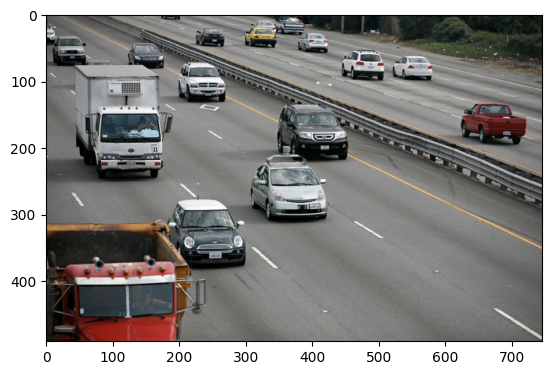

In [15]:
import matplotlib.image as mpimg

img = mpimg.imread('notebooks/car_image.png')
plt.imshow(img)
plt.show()


## Example Usage

You can use the following code to detect and count vehicles in an image. Replace the `image_path` with your image path or URL.

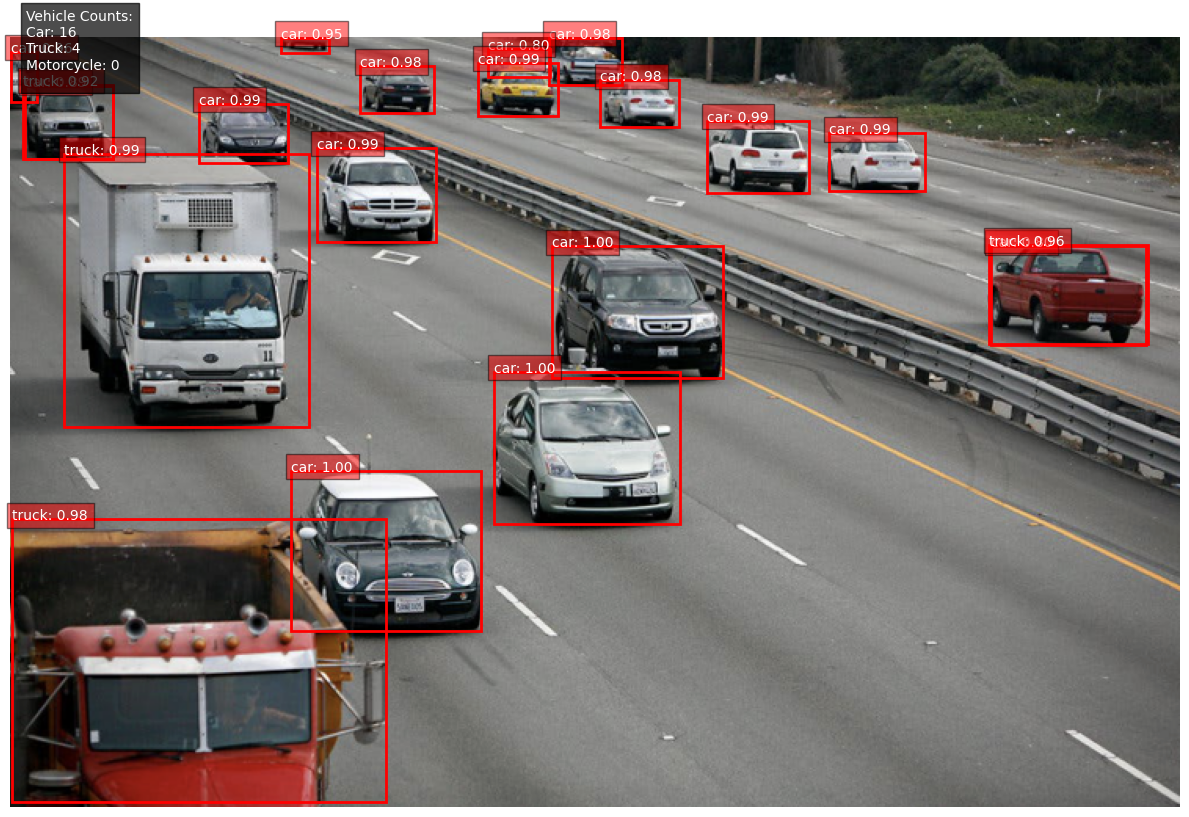

In [16]:
# Example usage
image_path = 'notebooks/car_image.png'  # Replace with your image path or URL
image, results, vehicle_counts = detect_vehicles(image_path)
visualize_detections(image, results, vehicle_counts)